load needed packages

In [28]:
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from xgboost import XGBClassifier
import sklearn.preprocessing as preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold,StratifiedShuffleSplit
import sklearn.linear_model as linear_model
from sklearn.metrics import mean_absolute_error, f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns",80)
from datetime import datetime

 import data and preconditioning

In [29]:
data_path = 'E:/Research/CE/ML/newdata.xlsx'
original_data = pd.read_excel(data_path)
original_data.columns = original_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
original_data = original_data[original_data.crash_severity != '99 - UNKNOWN']
original_data.columns #display column titles

Index(['crash_id', 'active_school_zone_flag',
       'adjusted_average_daily_traffic_amount',
       'adjusted_percentage_of_average_daily_traffic_for_trucks',
       'at_intersection_flag', 'commercial_motor_vehicle_flag',
       'construction_zone_flag', 'county', 'crash_severity', 'crash_time',
       'crash_year', 'curve_degrees', 'curve_length', 'curve_type',
       'day_of_week', 'first_harmful_event', 'highway_lane_design',
       'inside_shoulder_width_on_divided_highway', 'intersection_related',
       'latitude', 'left_shoulder_type', 'left_shoulder_use',
       'left_shoulder_width', 'light_condition', 'longitude',
       'manner_of_collision', 'median_type', 'median_width', 'number_of_lanes',
       'object_struck', 'right_shoulder_type', 'right_shoulder_use',
       'right_shoulder_width', 'road_class', 'roadway_alignment',
       'roadway_function', 'roadway_part', 'roadway_type', 'rural_flag',
       'rural_urban_type', 'speed_limit', 'surface_type', 'surface_width',
   

In [30]:
original_data = original_data[original_data.rural_urban_type != 'No Data']
print(original_data.info()) #general information about the columns
#int64: integer, object: mixture of all datatypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8859 entries, 0 to 13947
Data columns (total 58 columns):
crash_id                                                   8859 non-null int64
active_school_zone_flag                                    8859 non-null object
adjusted_average_daily_traffic_amount                      8859 non-null object
adjusted_percentage_of_average_daily_traffic_for_trucks    8859 non-null object
at_intersection_flag                                       8859 non-null bool
commercial_motor_vehicle_flag                              8859 non-null object
construction_zone_flag                                     8859 non-null object
county                                                     8859 non-null object
crash_severity                                             8859 non-null object
crash_time                                                 8859 non-null int64
crash_year                                                 8859 non-null int64
curve_degrees    

In [31]:
original_data['adjusted_average_daily_traffic_amount']=original_data['adjusted_average_daily_traffic_amount'].apply(pd.to_numeric, errors='coerce')
original_data['adjusted_percentage_of_average_daily_traffic_for_trucks']=original_data['adjusted_percentage_of_average_daily_traffic_for_trucks'].apply(pd.to_numeric, errors='coerce')
original_data['longitude']=original_data['longitude'].apply(pd.to_numeric, errors='coerce')
original_data['latitude']=original_data['latitude'].apply(pd.to_numeric, errors='coerce')
original_data['median_width']=original_data['median_width'].apply(pd.to_numeric, errors='coerce')
original_data['number_of_lanes']=original_data['number_of_lanes'].apply(pd.to_numeric, errors='coerce')
original_data['right_shoulder_width']=original_data['right_shoulder_width'].apply(pd.to_numeric, errors='coerce')
print(original_data.info()) #general information about the columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8859 entries, 0 to 13947
Data columns (total 58 columns):
crash_id                                                   8859 non-null int64
active_school_zone_flag                                    8859 non-null object
adjusted_average_daily_traffic_amount                      8859 non-null int64
adjusted_percentage_of_average_daily_traffic_for_trucks    8859 non-null float64
at_intersection_flag                                       8859 non-null bool
commercial_motor_vehicle_flag                              8859 non-null object
construction_zone_flag                                     8859 non-null object
county                                                     8859 non-null object
crash_severity                                             8859 non-null object
crash_time                                                 8859 non-null int64
crash_year                                                 8859 non-null int64
curve_degrees    

In [32]:
#all condidered features, removed crash ID, rural flag, rual urban type, object struck. Surface condition will be removed later.
#remove crash ID and rural flag since they are not related to crash severity by nature. 
#remove rural urban type and object struck due to the large percentile of no data in the columns
crash_features = [ 'active_school_zone_flag',
       'adjusted_average_daily_traffic_amount',
       'adjusted_percentage_of_average_daily_traffic_for_trucks',
       'at_intersection_flag', 'commercial_motor_vehicle_flag',
       'construction_zone_flag', 'county', 'crash_severity', 'crash_time',
       'crash_year', 
       'day_of_week', 'first_harmful_event', 'highway_lane_design',
       'inside_shoulder_width_on_divided_highway', 'intersection_related',
        'left_shoulder_type', 'left_shoulder_use',
       'left_shoulder_width', 'light_condition', 
       'manner_of_collision', 'median_type', 'median_width', 'number_of_lanes',
       'right_shoulder_type', 'right_shoulder_use',
       'right_shoulder_width', 'road_class', 'roadway_alignment',
       'roadway_function', 'roadway_part', 'roadway_type', 
       'speed_limit', 'surface_type', 
       'traffic_control_type', 'weather_condition', 'contributing_factor_1',
       'driver_license_class', 'driver_license_type', 'vehicle_body_style',
       'vehicle_travel_direction', 'person_age', 'person_ethnicity',
       'person_gender', 'person_restraint_used']

X = original_data[crash_features]
X.head() #display top few rows 

,active_school_zone_flag,adjusted_average_daily_traffic_amount,adjusted_percentage_of_average_daily_traffic_for_trucks,at_intersection_flag,commercial_motor_vehicle_flag,construction_zone_flag,county,crash_severity,crash_time,crash_year,day_of_week,first_harmful_event,highway_lane_design,inside_shoulder_width_on_divided_highway,intersection_related,left_shoulder_type,left_shoulder_use,left_shoulder_width,light_condition,manner_of_collision,median_type,median_width,number_of_lanes,right_shoulder_type,right_shoulder_use,right_shoulder_width,road_class,roadway_alignment,roadway_function,roadway_part,roadway_type,speed_limit,surface_type,traffic_control_type,weather_condition,contributing_factor_1,driver_license_class,driver_license_type,vehicle_body_style,vehicle_travel_direction,person_age,person_ethnicity,person_gender,person_restraint_used
0,No,23336,35.0,False,No,No,Callahan,N - NOT INJURED,929,2010,Saturday,Motor Vehicle In Transport,Freeway,4,Driveway Access,Surfaced,Emergency Only,8,Daylight,Angle - One Straight-One Left Turn,Positive Barrier,40,4,Surfaced,Emergency Only,20,Interstate,"Straight, Level",Rural Interstate,Service/Frontage Road,"4 Or More Lanes, Divided",45,No Data,No Passing Zone,Rain,None,Class C,Driver License,"Passenger Car, 2-Door",East,16,White,Female,Shoulder & Lap Belt
1,No,28778,31.4,False,Yes,No,Callahan,N - NOT INJURED,2025,2010,Friday,Motor Vehicle In Transport,Freeway,4,Non Intersection,Surfaced,Emergency Only,8,"Dark, Not Lighted",Same Direction - Both Going Straight-Sideswipe,Positive Barrier,40,4,Surfaced,Emergency Only,20,Interstate,"Straight, Grade",Rural Interstate,Main/Proper Lane,"4 Or More Lanes, Divided",65,No Data,Marked Lanes,Cloudy,Failed To Control Speed,Class C,Driver License,"Passenger Car, 2-Door",West,19,White,Male,Shoulder & Lap Belt
2,No,19832,38.2,False,No,No,Callahan,B - NON-INCAPACITATING INJURY,1318,2010,Sunday,Fixed Object,Freeway,4,Non Intersection,Surfaced,Emergency Only,8,Daylight,One Motor Vehicle - Going Straight,Positive Barrier,40,4,Surfaced,Emergency Only,20,Interstate,"Straight, Level",Rural Interstate,Main/Proper Lane,"4 Or More Lanes, Divided",70,No Data,Center Stripe/Divider,Fog,Failed To Drive In Single Lane,Class C,Driver License,"Passenger Car, 4-Door",East,18,Black,Female,Shoulder & Lap Belt
3,No,28778,31.4,False,No,No,Callahan,N - NOT INJURED,850,2010,Thursday,Fixed Object,Freeway,4,Non Intersection,Surfaced,Emergency Only,8,Daylight,One Motor Vehicle - Going Straight,Positive Barrier,40,4,Surfaced,Emergency Only,20,Interstate,"Straight, Level",Rural Interstate,Main/Proper Lane,"4 Or More Lanes, Divided",70,No Data,None,Snow,Other (Explain In Narrative),Class C,Driver License,Sport Utility Vehicle,West,20,White,Male,Shoulder & Lap Belt
4,No,23336,35.0,False,No,No,Callahan,N - NOT INJURED,1854,2010,Sunday,Fixed Object,Freeway,4,Non Intersection,Surfaced,Emergency Only,8,"Dark, Not Lighted",One Motor Vehicle - Going Straight,Positive Barrier,40,4,Surfaced,Emergency Only,20,Interstate,"Straight, Level",Rural Interstate,Main/Proper Lane,"4 Or More Lanes, Divided",65,No Data,Center Stripe/Divider,Clear,None,Class C,Driver License,"Passenger Car, 2-Door",West,18,Hispanic,Female,Shoulder & Lap Belt


In [33]:
features = X.copy() #make a copy
features['crash_severity'].value_counts()

N - NOT INJURED                  5936
B - NON-INCAPACITATING INJURY    1307
C - POSSIBLE INJURY              1077
A - SUSPECTED SERIOUS INJURY      402
K - KILLED                        137
Name: crash_severity, dtype: int64

In [34]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [35]:
# Encode the other categorical features as numbers with One Hot Encoder
cleanup = {"crash_severity": {"N - NOT INJURED": 0, "B - NON-INCAPACITATING INJURY": 1, "C - POSSIBLE INJURY": 2, 
                             "A - SUSPECTED SERIOUS INJURY": 3, "K - KILLED": 4}}
features.replace(cleanup, inplace=True)
target = features["crash_severity"]
features.drop(["crash_severity"], inplace=True, axis=1)
#divide columns into numerical/categorical
categorical_subset = features.select_dtypes("object")
numerical_subset = features.drop(categorical_subset, axis=1)
ohe_fields = list(categorical_subset.columns)
df_ohe = pd.get_dummies(features,columns=ohe_fields)
ohe_feature_names = pd.get_dummies(features[ohe_fields],columns=ohe_fields).columns.tolist()
df_ohe.head()

,adjusted_average_daily_traffic_amount,adjusted_percentage_of_average_daily_traffic_for_trucks,at_intersection_flag,crash_time,crash_year,median_width,number_of_lanes,right_shoulder_width,speed_limit,person_age,active_school_zone_flag_No,active_school_zone_flag_Yes,commercial_motor_vehicle_flag_No,commercial_motor_vehicle_flag_Yes,construction_zone_flag_No,construction_zone_flag_Yes,county_Callahan,county_Eastland,county_Ector,county_Erath,county_Hale,county_Hood,county_Howard,county_Jones,county_Lubbock,county_Midland,county_Parker,county_Potter,county_Randall,county_Runnels,county_Taylor,county_Tom Green,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,first_harmful_event_Animal,...,vehicle_body_style_Farm Equipment,vehicle_body_style_Fire Truck,vehicle_body_style_No Data,vehicle_body_style_Other (Explain In Narrative),"vehicle_body_style_Passenger Car, 2-Door","vehicle_body_style_Passenger Car, 4-Door",vehicle_body_style_Pickup,vehicle_body_style_Sport Utility Vehicle,vehicle_body_style_Truck,vehicle_body_style_Truck Tractor,vehicle_body_style_Unknown,vehicle_body_style_Van,vehicle_travel_direction_11,vehicle_travel_direction_East,vehicle_travel_direction_North,vehicle_travel_direction_Northeast,vehicle_travel_direction_Northwest,vehicle_travel_direction_South,vehicle_travel_direction_Southeast,vehicle_travel_direction_Southwest,vehicle_travel_direction_West,person_ethnicity_Amer. Indian/Alaskan Native,person_ethnicity_Asian,person_ethnicity_Black,person_ethnicity_Hispanic,person_ethnicity_No Data,person_ethnicity_Other,person_ethnicity_Unknown,person_ethnicity_White,person_gender_Female,person_gender_Male,person_gender_Unknown,person_restraint_used_Lap Belt Only,person_restraint_used_No Data,person_restraint_used_None,person_restraint_used_Not Applicable,person_restraint_used_Other (Explain In Narrative),person_restraint_used_Shoulder & Lap Belt,person_restraint_used_Shoulder Belt Only,person_restraint_used_Unknown
0,23336,35.0,False,929,2010,40,4,20,45,16,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0
1,28778,31.4,False,2025,2010,40,4,20,65,19,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
2,19832,38.2,False,1318,2010,40,4,20,70,18,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,28778,31.4,False,850,2010,40,4,20,70,20,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
4,23336,35.0,False,1854,2010,40,4,20,65,18,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [36]:
#standardize continuous features
float_values = numerical_subset.values
float_feature_names = list(numerical_subset.columns)
scaler = StandardScaler()
float_scaled = scaler.fit_transform(float_values)
df_ohe[float_feature_names] = float_scaled
with open('scalers.pkl','wb') as fp:
    pickle.dump(scaler,fp)
df_ohe = df_ohe.xs(float_feature_names+ohe_feature_names,axis=1)

C:\Users\amand\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\amand\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [37]:
X = df_ohe.values
y = target.values
feature_names = df_ohe.columns.tolist()

In [38]:
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)
feature_sel = range(len(feature_names))
fnames = np.array(feature_names)[feature_sel]

In [39]:
#fit model on training data
dtrain = xgb.DMatrix(X_train, label=y_train,feature_names=fnames)
dtest = xgb.DMatrix(X_test, label=y_test,feature_names=fnames)
mean_train = np.mean(y_train)
baseline_predictions = np.ones(y_test.shape) * mean_train
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print("Baseline MAE is {:.10f}".format(mae_baseline))

Baseline MAE is 0.8053601206


In [40]:
params = {
    #parameters that we are going to tune.
    'max_depth':5,
    'min_child_weight': 3,
    'eta':.2,
    'subsample': 1,
    'colsample_bytree': 1,
    #other parameters
    'objective':'reg:linear',
}
params['eval_metric'] = "mae"
num_boost_round = 999
start_time = timer(None)
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)
timer(start_time)
print("Best MAE: {:.10f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[0]	Test-mae:0.765164
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:0.757717
[2]	Test-mae:0.75329
[3]	Test-mae:0.750765
[4]	Test-mae:0.750591
[5]	Test-mae:0.749185
[6]	Test-mae:0.74784
[7]	Test-mae:0.744591
[8]	Test-mae:0.74174
[9]	Test-mae:0.742574
[10]	Test-mae:0.742035
[11]	Test-mae:0.740183
[12]	Test-mae:0.738899
[13]	Test-mae:0.738083
[14]	Test-mae:0.736636
[15]	Test-mae:0.735101
[16]	Test-mae:0.734834
[17]	Test-mae:0.733776
[18]	Test-mae:0.73181
[19]	Test-mae:0.730074
[20]	Test-mae:0.729644
[21]	Test-mae:0.728224
[22]	Test-mae:0.727501
[23]	Test-mae:0.725833
[24]	Test-mae:0.725002
[25]	Test-mae:0.724144
[26]	Test-mae:0.723742
[27]	Test-mae:0.722624
[28]	Test-mae:0.721654
[29]	Test-mae:0.721441
[30]	Test-mae:0.720709
[31]	Test-mae:0.720732
[32]	Test-mae:0.719224
[33]	Test-mae:0.718273
[34]	Test-mae:0.718456
[35]	Test-mae:0.718132
[36]	Test-mae:0.718364
[37]	Test-mae:0.718117
[38]	Test-mae:0.717466
[39]	Test-mae:0.717161
[40]	Test-mae:0.716798
[41]	Test-mae:0

In [41]:
#use AUC score for further hyperparameter tuning
params['eval_metric'] = "auc"
num_boost_round = 999
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best AUC: {:.10f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[0]	Test-auc:0.746124
Will train until Test-auc hasn't improved in 10 rounds.
[1]	Test-auc:0.755491
[2]	Test-auc:0.780225
[3]	Test-auc:0.812123
[4]	Test-auc:0.828231
[5]	Test-auc:0.838871
[6]	Test-auc:0.846669
[7]	Test-auc:0.845201
[8]	Test-auc:0.858716
[9]	Test-auc:0.85196
[10]	Test-auc:0.85263
[11]	Test-auc:0.854103
[12]	Test-auc:0.859161
[13]	Test-auc:0.856892
[14]	Test-auc:0.859272
[15]	Test-auc:0.860665
[16]	Test-auc:0.859379
[17]	Test-auc:0.857691
[18]	Test-auc:0.864581
[19]	Test-auc:0.864476
[20]	Test-auc:0.862804
[21]	Test-auc:0.864314
[22]	Test-auc:0.866078
[23]	Test-auc:0.869425
[24]	Test-auc:0.871375
[25]	Test-auc:0.871941
[26]	Test-auc:0.871434
[27]	Test-auc:0.873303
[28]	Test-auc:0.875035
[29]	Test-auc:0.875194
[30]	Test-auc:0.875152
[31]	Test-auc:0.874636
[32]	Test-auc:0.877806
[33]	Test-auc:0.877471
[34]	Test-auc:0.873324
[35]	Test-auc:0.873723
[36]	Test-auc:0.87051
[37]	Test-auc:0.870069
[38]	Test-auc:0.869614
[39]	Test-auc:0.870271
[40]	Test-auc:0.870653
[41]	Test-auc:

In [42]:
#tune the pair of max_depth and min_child_weight
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [43]:
max_auc = 0
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    #update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    #run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
    #update best AUC
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

CV with max_depth=9, min_child_weight=5


C:\Users\amand\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


	AUC 0.8064932 for 17 rounds
CV with max_depth=9, min_child_weight=6
	AUC 0.7917084 for 10 rounds
CV with max_depth=9, min_child_weight=7
	AUC 0.8021480000000001 for 9 rounds
CV with max_depth=10, min_child_weight=5
	AUC 0.797299 for 12 rounds
CV with max_depth=10, min_child_weight=6
	AUC 0.8015792000000002 for 11 rounds
CV with max_depth=10, min_child_weight=7
	AUC 0.7913684 for 18 rounds
CV with max_depth=11, min_child_weight=5
	AUC 0.7866949999999999 for 12 rounds
CV with max_depth=11, min_child_weight=6
	AUC 0.791589 for 14 rounds
CV with max_depth=11, min_child_weight=7
	AUC 0.7805066 for 11 rounds
Best params: 9, 5, AUC: 0.8064932


In [44]:
#update the best values for the pair above
params['max_depth'] = 9
params['min_child_weight'] = 5

In [46]:
#tune the pair of subsample and colsample
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]
max_auc = 0
best_params = None
#start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    #update parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    #run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
    #update best score
    max_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (subsample,colsample)
#print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

CV with subsample=1.0, colsample=1.0


C:\Users\amand\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


	AUC 0.7805066 for 17 rounds
CV with subsample=1.0, colsample=0.9
	AUC 0.7805066 for 13 rounds
CV with subsample=1.0, colsample=0.8
	AUC 0.7805066 for 12 rounds
CV with subsample=1.0, colsample=0.7
	AUC 0.7805066 for 10 rounds
CV with subsample=0.9, colsample=1.0
	AUC 0.7805066 for 8 rounds
CV with subsample=0.9, colsample=0.9
	AUC 0.7805066 for 16 rounds
CV with subsample=0.9, colsample=0.8
	AUC 0.7805066 for 12 rounds
CV with subsample=0.9, colsample=0.7
	AUC 0.7805066 for 12 rounds
CV with subsample=0.8, colsample=1.0
	AUC 0.7805066 for 9 rounds
CV with subsample=0.8, colsample=0.9
	AUC 0.7805066 for 8 rounds
CV with subsample=0.8, colsample=0.8
	AUC 0.7805066 for 14 rounds
CV with subsample=0.8, colsample=0.7
	AUC 0.7805066 for 13 rounds
CV with subsample=0.7, colsample=1.0
	AUC 0.7805066 for 6 rounds
CV with subsample=0.7, colsample=0.9
	AUC 0.7805066 for 9 rounds
CV with subsample=0.7, colsample=0.8
	AUC 0.7805066 for 10 rounds
CV with subsample=0.7, colsample=0.7
	AUC 0.7805066 

In [50]:
params['subsample'] = 0.9
params['colsample_bytree'] = 1.0

In [48]:
#tune eta
max_auc = 0
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    #update parameters
    params['eta'] = eta
    #run and time each CV
    %time cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=42, nfold=5, metrics=['auc'], early_stopping_rounds=10)
    #update best score
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds\n".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = eta
print("Best params: {}, AUC: {}".format(best_params, max_auc))

CV with eta=0.3
Wall time: 6.25 s
	AUC 0.7935422 for 6 rounds

CV with eta=0.2


C:\Users\amand\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  if sys.path[0] == '':


Wall time: 6.19 s
	AUC 0.8040670000000001 for 8 rounds

CV with eta=0.1
Wall time: 7.58 s
	AUC 0.8141994 for 17 rounds

CV with eta=0.05
Wall time: 15.7 s
	AUC 0.8266032000000001 for 45 rounds

CV with eta=0.01
Wall time: 17.9 s
	AUC 0.8117504 for 49 rounds

CV with eta=0.005
Wall time: 22.4 s
	AUC 0.8108782 for 67 rounds

Best params: 0.05, AUC: 0.8266032000000001


In [51]:
params['eta'] = .05
#check all parameters tuned
params

{'max_depth': 9,
 'min_child_weight': 5,
 'eta': 0.05,
 'subsample': 0.9,
 'colsample_bytree': 1.0,
 'objective': 'reg:linear',
 'eval_metric': 'auc'}

In [52]:
model = xgb.train(
    params,
    dtest,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)
print("Best AUC: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[0]	Test-auc:1.03293
Will train until Test-auc hasn't improved in 10 rounds.
[1]	Test-auc:1.09519
[2]	Test-auc:1.10454
[3]	Test-auc:1.12132
[4]	Test-auc:1.1492
[5]	Test-auc:1.17588
[6]	Test-auc:1.17997
[7]	Test-auc:1.19359
[8]	Test-auc:1.19209
[9]	Test-auc:1.19498
[10]	Test-auc:1.19632
[11]	Test-auc:1.19849
[12]	Test-auc:1.20348
[13]	Test-auc:1.22177
[14]	Test-auc:1.23318
[15]	Test-auc:1.23876
[16]	Test-auc:1.24482
[17]	Test-auc:1.2453
[18]	Test-auc:1.2537
[19]	Test-auc:1.25443
[20]	Test-auc:1.26432
[21]	Test-auc:1.26481
[22]	Test-auc:1.2757
[23]	Test-auc:1.27992
[24]	Test-auc:1.28625
[25]	Test-auc:1.29141
[26]	Test-auc:1.29444
[27]	Test-auc:1.29968
[28]	Test-auc:1.30726
[29]	Test-auc:1.31062
[30]	Test-auc:1.31101
[31]	Test-auc:1.31294
[32]	Test-auc:1.32117
[33]	Test-auc:1.32411
[34]	Test-auc:1.32836
[35]	Test-auc:1.33074
[36]	Test-auc:1.33717
[37]	Test-auc:1.3473
[38]	Test-auc:1.35446
[39]	Test-auc:1.36209
[40]	Test-auc:1.36538
[41]	Test-auc:1.36987
[42]	Test-auc:1.37335
[43]	Test-auc

[361]	Test-auc:1.4681
[362]	Test-auc:1.4681
[363]	Test-auc:1.4681
[364]	Test-auc:1.4681
[365]	Test-auc:1.4681
[366]	Test-auc:1.4681
[367]	Test-auc:1.4681
[368]	Test-auc:1.4681
[369]	Test-auc:1.4681
[370]	Test-auc:1.4681
[371]	Test-auc:1.4681
[372]	Test-auc:1.4681
Stopping. Best iteration:
[362]	Test-auc:1.4681

Best AUC: 1.47 in 363 rounds


In [53]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtest,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-auc:1.03293
[1]	Test-auc:1.09519
[2]	Test-auc:1.10454
[3]	Test-auc:1.12132
[4]	Test-auc:1.1492
[5]	Test-auc:1.17588
[6]	Test-auc:1.17997
[7]	Test-auc:1.19359
[8]	Test-auc:1.19209
[9]	Test-auc:1.19498
[10]	Test-auc:1.19632
[11]	Test-auc:1.19849
[12]	Test-auc:1.20348
[13]	Test-auc:1.22177
[14]	Test-auc:1.23318
[15]	Test-auc:1.23876
[16]	Test-auc:1.24482
[17]	Test-auc:1.2453
[18]	Test-auc:1.2537
[19]	Test-auc:1.25443
[20]	Test-auc:1.26432
[21]	Test-auc:1.26481
[22]	Test-auc:1.2757
[23]	Test-auc:1.27992
[24]	Test-auc:1.28625
[25]	Test-auc:1.29141
[26]	Test-auc:1.29444
[27]	Test-auc:1.29968
[28]	Test-auc:1.30726
[29]	Test-auc:1.31062
[30]	Test-auc:1.31101
[31]	Test-auc:1.31294
[32]	Test-auc:1.32117
[33]	Test-auc:1.32411
[34]	Test-auc:1.32836
[35]	Test-auc:1.33074
[36]	Test-auc:1.33717
[37]	Test-auc:1.3473
[38]	Test-auc:1.35446
[39]	Test-auc:1.36209
[40]	Test-auc:1.36538
[41]	Test-auc:1.36987
[42]	Test-auc:1.37335
[43]	Test-auc:1.37696
[44]	Test-auc:1.37925
[45]	Test-auc:1.38072
[46

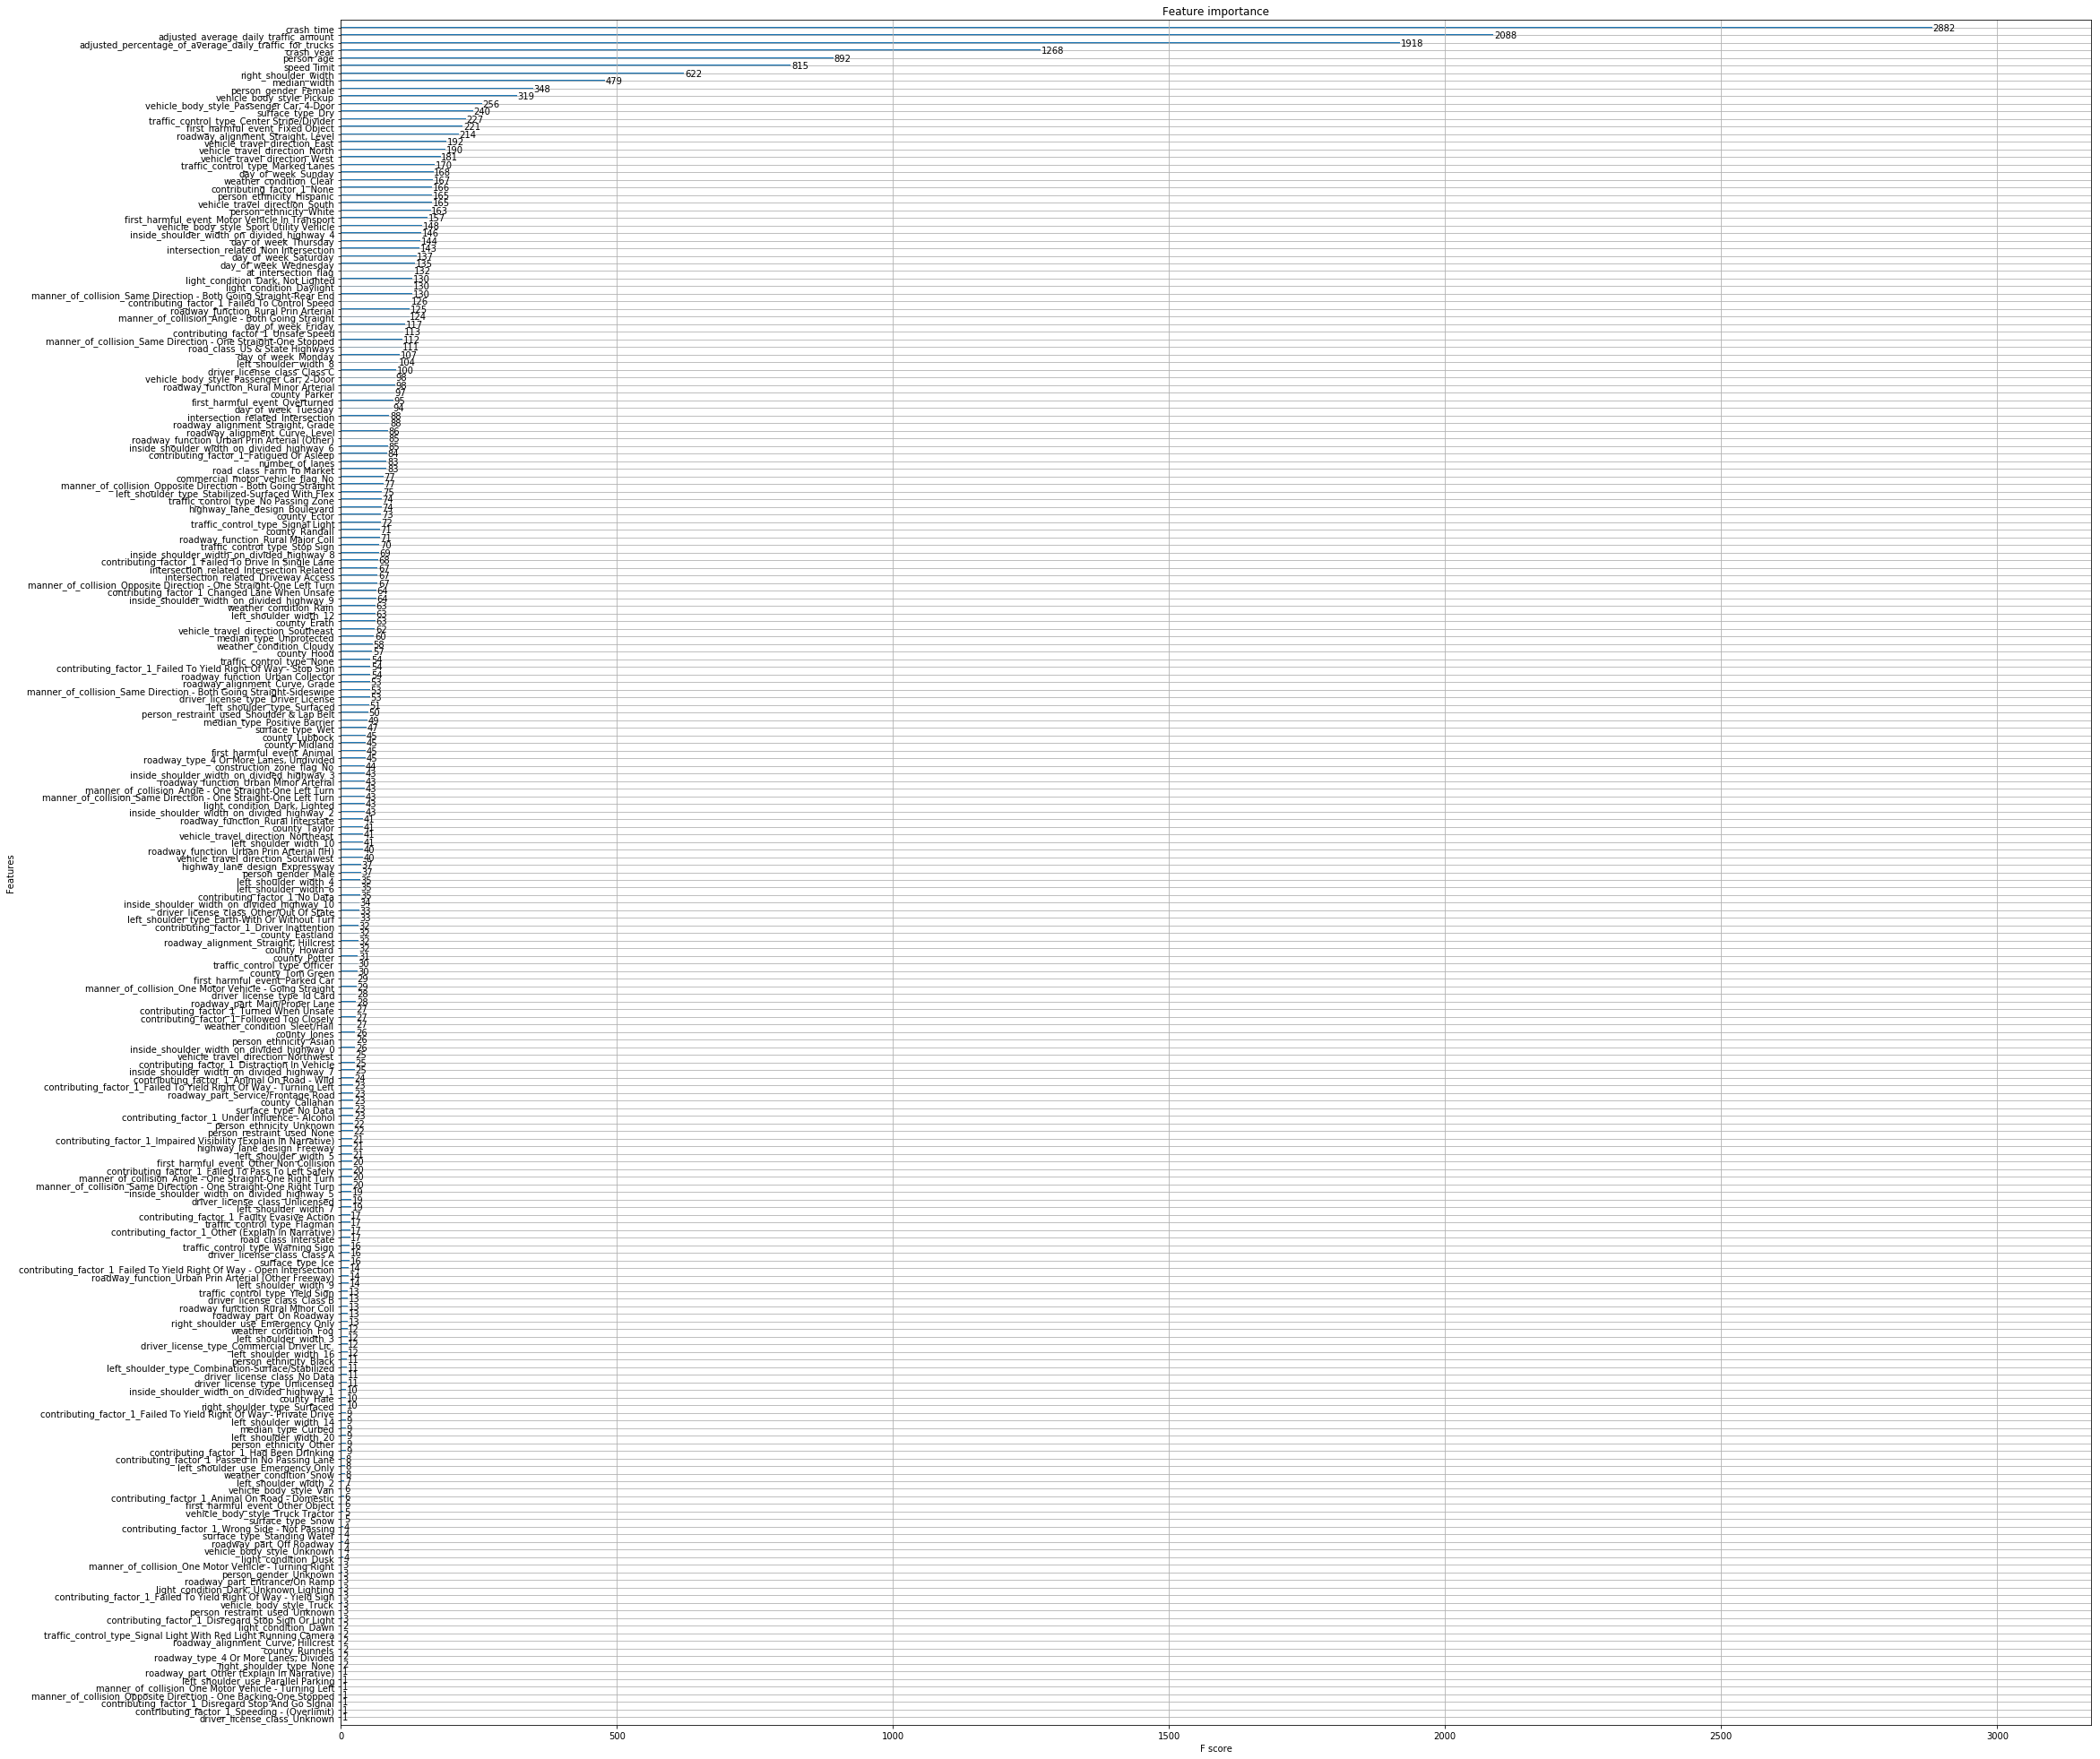

In [54]:
plt.figure(figsize=(35,35))
xgb.plot_importance(best_model,ax=plt.gca(),importance_type='weight')

In [ ]:
#best_model.save_model("label_encoding_all.model")